Loading image: water.tiff
Searching for a redundant palette to demonstrate SOP 2...
Found worst-case conflict: Delta E = 2.25


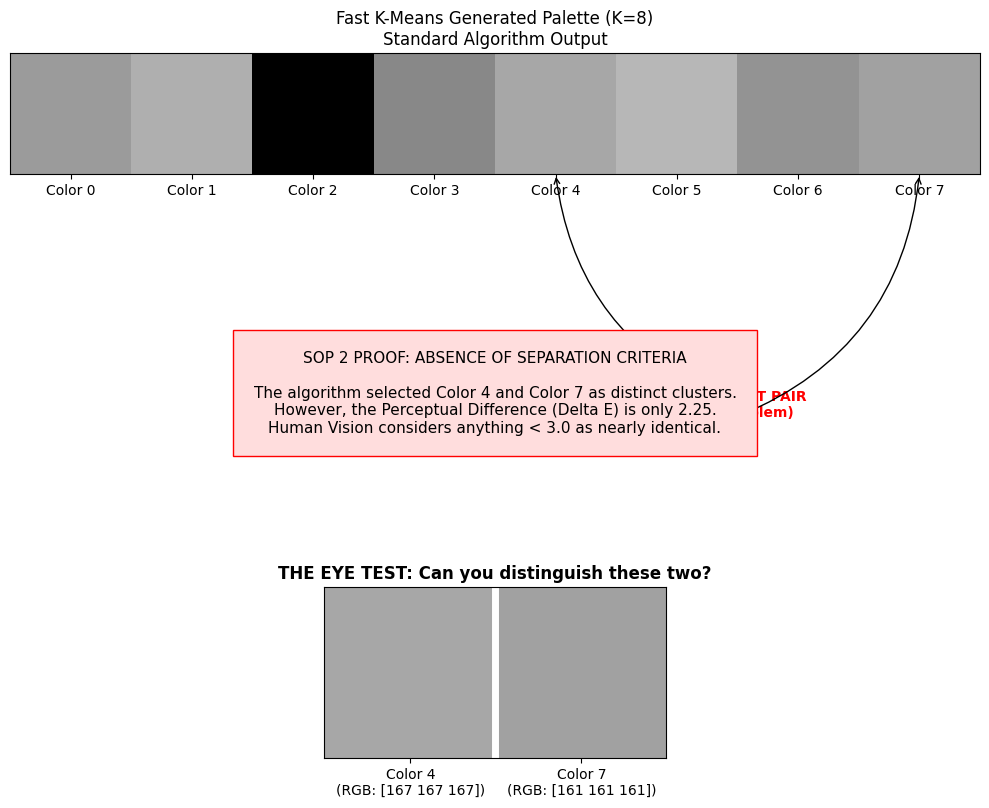

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from skimage import io, color
from math import sqrt
import glob
import os

# ==========================================
# CONFIGURATION: TYPE YOUR IMAGE NAME HERE
# ==========================================
TARGET_IMAGE_NAME = "water.tiff"  # <-- Change this to your specific file name (e.g., "my_image.tiff")

# ==========================================
# 1. SETUP & HELPER FUNCTIONS
# ==========================================

def rgb_to_lab_one_pixel(pixel_rgb):
    rgb_norm = np.array(pixel_rgb).reshape(1, 1, 3) / 255.0
    lab_pixel = color.rgb2lab(rgb_norm)
    return lab_pixel[0, 0, :]

def calc_delta_e(c1, c2):
    l1, a1, b1 = rgb_to_lab_one_pixel(c1)
    l2, a2, b2 = rgb_to_lab_one_pixel(c2)
    return sqrt((l1-l2)**2 + (a1-a2)**2 + (b1-b2)**2)

# Load Image (Updated for flexibility)
img = None
try:
    image_path = None
    
    # Priority 1: Check the specific file user typed above
    if TARGET_IMAGE_NAME and os.path.exists(TARGET_IMAGE_NAME):
        image_path = TARGET_IMAGE_NAME
    
    # Priority 2: Auto-search if specific file not found
    else:
        if TARGET_IMAGE_NAME:
            print(f"Warning: '{TARGET_IMAGE_NAME}' not found. Searching for other images...")
            
        search_patterns = ['*.tiff', '*.tif', '*.jpg', '*.jpeg', '*.png', '*.bmp']
        found_files = []
        for pattern in search_patterns:
            found_files.extend(glob.glob(pattern))

        if found_files:
            image_path = found_files[0] # Use the first valid image found

    if image_path:
        print(f"Loading image: {image_path}")
        img = io.imread(image_path)

        # Handle images with 4 channels (RGBA) by keeping only RGB
        if len(img.shape) == 3 and img.shape[2] == 4:
            img = img[:, :, :3]
            
        # Handle grayscale images
        if len(img.shape) == 2:
            img = color.gray2rgb(img)
            
    else:
        raise FileNotFoundError("No image files found in directory.")

except Exception as e:
    print(f"Image load error: {e}. Using dummy data.")
    img = np.zeros((100, 100, 3), dtype=np.uint8)
    img[:,:,0] = 200 # Red background

pixels = img.reshape(-1, 3)
K = 8

# ==========================================
# 2. THE "HUNTER" LOOP
# ==========================================
# We run the algorithm multiple times to find the *worst* possible result 
# to demonstrate the flaw to the panel clearly.

print("Searching for a redundant palette to demonstrate SOP 2...")
worst_palette = None
worst_conflict = None # (index1, index2, delta_e)
min_delta_e_found = 100.0

for seed in range(20): # Try 20 different random starts
    kmeans = MiniBatchKMeans(n_clusters=K, random_state=seed, n_init=3)
    kmeans.fit(pixels)
    palette = kmeans.cluster_centers_.astype(int)
    
    # Check this palette for conflicts
    local_min_dist = 100.0
    local_conflict = None
    
    for i in range(K):
        for j in range(i + 1, K): # Check unique pairs
            dist = calc_delta_e(palette[i], palette[j])
            if dist < local_min_dist:
                local_min_dist = dist
                local_conflict = (i, j, dist)
    
    # If this is the "worst" palette we've seen (lowest distance), save it
    if local_min_dist < min_delta_e_found:
        min_delta_e_found = local_min_dist
        worst_palette = palette
        worst_conflict = local_conflict
    
    # If we found a "smoking gun" (Delta E < 5), stop looking
    if min_delta_e_found < 5.0:
        break

print(f"Found worst-case conflict: Delta E = {min_delta_e_found:.2f}")

# ==========================================
# 3. CREATE THE VISUAL PROOF
# ==========================================

idx1, idx2, dist_val = worst_conflict
color_a = worst_palette[idx1]
color_b = worst_palette[idx2]

fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(3, 1, height_ratios=[2, 1, 2])

# PLOT 1: The Generated Palette
ax1 = fig.add_subplot(gs[0])
ax1.imshow([worst_palette])
ax1.set_title(f"Fast K-Means Generated Palette (K={K})\nStandard Algorithm Output", fontsize=12)
ax1.set_yticks([])
ax1.set_xticks(np.arange(K))
ax1.set_xticklabels([f"Color {i}" for i in range(K)])

# DRAW A CONNECTOR LINE identifying the bad pair
# We use an arrow to point to the two redundant colors
y_arrow = -0.6
ax1.annotate(f"REDUNDANT PAIR\n(The Problem)", xy=(idx1, 0.5), xytext=((idx1+idx2)/2, 2.5),
            arrowprops=dict(facecolor='red', arrowstyle='->', connectionstyle="arc3,rad=-0.3"),
            ha='center', color='red', fontsize=10, weight='bold')
ax1.annotate("", xy=(idx2, 0.5), xytext=((idx1+idx2)/2, 2.5),
            arrowprops=dict(facecolor='red', arrowstyle='->', connectionstyle="arc3,rad=0.3"))

# PLOT 2: The Logic Gap Text
ax2 = fig.add_subplot(gs[1])
ax2.axis('off')
explanation = (
    f"SOP 2 PROOF: ABSENCE OF SEPARATION CRITERIA\n\n"
    f"The algorithm selected Color {idx1} and Color {idx2} as distinct clusters.\n"
    f"However, the Perceptual Difference (Delta E) is only {dist_val:.2f}.\n"
    f"Human Vision considers anything < 3.0 as nearly identical."
)
ax2.text(0.5, 0.5, explanation, ha='center', va='center', fontsize=11, 
         bbox=dict(facecolor='#ffdddd', edgecolor='red', pad=15))

# PLOT 3: The "Side-by-Side" Test
ax3 = fig.add_subplot(gs[2])
# Create a split image comparing just the two colors
comparison_img = np.zeros((100, 200, 3), dtype=np.uint8)
comparison_img[:, :100] = color_a
comparison_img[:, 100:] = color_b

ax3.imshow(comparison_img)
ax3.set_title(f"THE EYE TEST: Can you distinguish these two?", fontweight='bold', fontsize=12)
ax3.set_xticks([50, 150])
ax3.set_xticklabels([f"Color {idx1}\n(RGB: {color_a})", f"Color {idx2}\n(RGB: {color_b})"])
ax3.set_yticks([])

# Add a vertical divider line
ax3.axvline(x=99.5, color='white', linewidth=5)

plt.tight_layout()
plt.show()